# Timings
### David Widmann

# Intro

In this document we compare the timings of different calibration error estimators.

# Packages

In [1]:
using CalibrationPaper
using CalibrationErrors
using CalibrationTests
using CSV
using DataFrames
using Plots
using Query

using LinearAlgebra
using Random

theme(:wong2)
gr()

Plots.GRBackend()

# Experiments

## Intro

Since we are only interested in a comparison of the computational times, we just sample
predictions and labels uniformly at random from the probability simplex and the labels
$\{1, \ldots, n\}$.

We evaluate the histogram-regression estimator of the expected calibration error (ECE)
with respect to the total variation distance, both with 10 equally sized bins per
dimension and data dependent bins. Additionally, we compute the biased and unbiased
estimates of the squared kernel calibration error (SKCE) with respect to a matrix-valued
kernel $K(x, \tilde{x}) = k(x, \tilde{x}) I$, where $k$ is a scalar-valued exponential
kernel. The bandwidth of the kernel is chosen by the median heuristic.

## Benchmarking routine

The following function defines our benchmarking routine.

In [2]:
function benchmark(estimator, nclasses::Int, nsamples::Int)
    # sample uniformly distributed predictions and labels
    predictions = [randexp(nclasses) for _ in 1:nsamples]
    for prediction in predictions
        ldiv!(sum(prediction), prediction)
    end
    labels = rand(1:nclasses, nsamples)

    # define estimator (can be data dependent)
    if estimator isa CalibrationErrors.CalibrationErrorEstimator
        _estimator = estimator
    else
        _estimator = estimator(predictions)
    end

    # define function that measures the time of calibration estimation
    f = let predictions = predictions, labels = labels, estimator = _estimator
        i -> @elapsed calibrationerror(estimator, predictions, labels)
    end

    # compile function
    f(0)

    # compute minimum time out of 20 runs
    mapreduce(f, min, 1:20)
end

benchmark (generic function with 1 method)

As mentioned above, we compare different calibration error estimators. We investigate
data sets of 10 different sizes with 2, 10, 100, and 1000 classes. The results are saved
as a CSV file.

In [3]:
function benchmark()
    # do not overwrite existing results
    file = joinpath(@__DIR__, "..", "data", "timings.csv")
    isfile(file) && return

    # define estimators and labels
    estimators = [ECE(UniformBinning(10)), ECE(MedianVarianceBinning(5)),
                    predictions -> BiasedSKCE(median_TV_kernel(predictions)),
                    predictions -> QuadraticUnbiasedSKCE(median_TV_kernel(predictions)),
                    predictions -> LinearUnbiasedSKCE(median_TV_kernel(predictions))]
    labels = ["ECE_uniform", "ECE_dynamic", "SKCEb_median", "SKCEuq_median",
              "SKCEul_median"]

    # define number of samples
    nsamples = round.(Int, 10 .^ LinRange(1, 3, 10))

    # define number of classes
    nclasses = [2, 10, 100, 1_000]

    times = Array{Float64}(undef, length(estimators), length(nclasses), length(nsamples))
    @inbounds for k in 1:length(nsamples), j in 1:length(nclasses), i in 1:length(estimators)
        # set seed
        Random.seed!(1234)

        times[i, j, k] = benchmark(estimators[i], nclasses[j], nsamples[k])
    end

    # save results
    open(file, "w") do f
        @inbounds for k in 1:length(nsamples), j in 1:length(nclasses)
            df = DataFrame(estimator = labels, nclasses = nclasses[j],
                           nsamples = nsamples[k], time = view(times, :, j, k))

            CSV.write(f, df; append = k > 1 || j > 1)
        end
    end

    nothing
end

benchmark()

We plot the timings for each estimator, grouped by the number of classes.

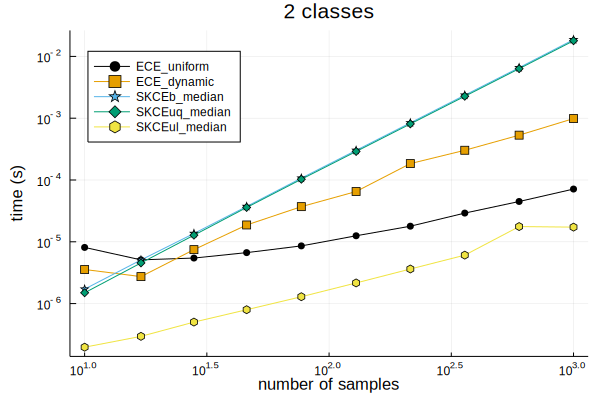

In [4]:
function plotbenchmark(nclasses)
    # load and preprocess data
    df = CSV.read(joinpath(@__DIR__, "..", "data", "timings.csv"))
    groups = df |>
        @filter(_.nclasses == nclasses) |>
        @groupby(_.estimator) |>
        @orderby(_.nsamples)

    # plot the data in logarithmic scale
    plt = plot(title = "$nclasses classes", xscale = :log10, yscale = :log10,
               xlabel = "number of samples", ylabel = "time (s)", legend = :topleft)
    for g in groups
        estimator = first(g).estimator
        plot!(plt, getfield.(g, :nsamples), getfield.(g, :time);
             label = estimator, markershape = :auto)
    end

    plt
end

plotbenchmark(2)

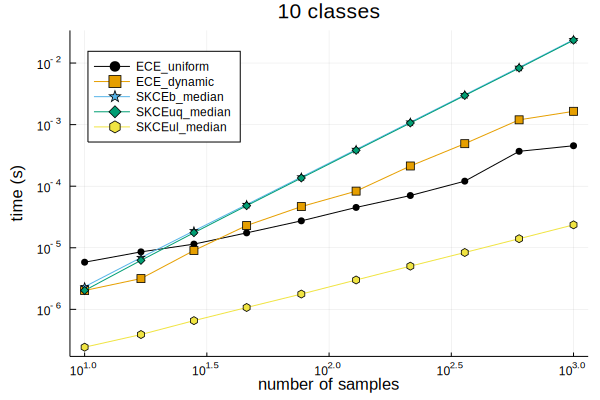

In [5]:
plotbenchmark(10)

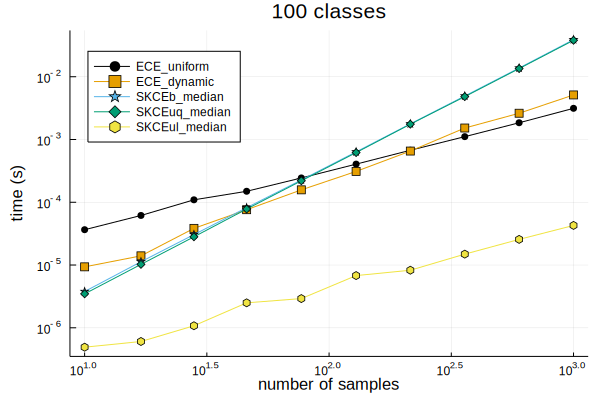

In [6]:
plotbenchmark(100)

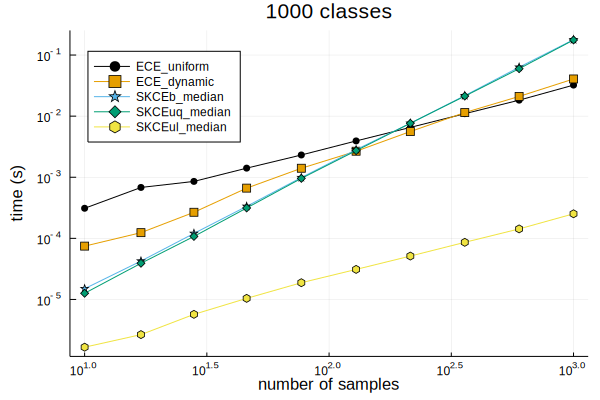

In [7]:
plotbenchmark(1_000)